# Análisis del dataset de entrenamiento


In [1]:
import pandas as pd
import random
import os
import copy
import math

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
WORDCLOUD_SEED = 37
RANDOM_SEED = 21

random.seed(RANDOM_SEED)

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danny\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. Análisis de frecuencia de palabras


En textos de de humor es común que se sigan ciertos patrones o se utilicen ciertas palabras con sentido de humor como "JAJA" o "#humor" que los modelos pueden asociar erróneamente a niveles de humor durante el finetuning. También pueden haber palabras poco frecuentes entre la clases humor y no humor que el modelo pueden aprender a asociar a estas clases.

En este notebook realizamos un análisis de frecuencia de palabras por cada clase en el dataset de entrenamiento ubicado en la ruta `./data/processed/haha_train.csv` para identificar estas palabras, palabras con sentido de humor por clase y palabras poco frecuentes por clase. El objetivo de este análisis es extender el dataset de entrenamiento con instancias que incluyan estas palabras para hacer más resistente el modelo a estos patrones y mejorar su rendimiento en las tareas de detección y clasificación.


In [4]:
processed_file_path = '../data/processed/haha_train.csv'

processed_df = pd.read_csv(processed_file_path, sep=',', encoding='utf-8')

processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    24000 non-null  object
 1   score   24000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 375.1+ KB


In [5]:
print("Cantidad de textos por clase:")
text_counts = processed_df['score'].value_counts()
text_counts = text_counts.sort_index()
pd.DataFrame(text_counts)

Cantidad de textos por clase:


,count
score,
0,14766
1,3005
2,2337
3,2412
4,1168
5,312


In [6]:
score_classes = text_counts.index.to_list()
score_classes

[0, 1, 2, 3, 4, 5]

In [7]:
detection_classes = [0, 1]

In [8]:
def custom_tokenizer(text):
  # Regex para hacer match de hashtags, emojis, y palabras.
  pattern = r"(\#[a-zA-Z0-9_]+|[^\w\s,]|[\w]+|[\U00010000-\U0010ffff])"
  return re.findall(pattern, text)

Se define un conjunto de palabras o partes de palabras con significado relacionado a humor, como sinónimos o antónimos de humor, modos de humor, hashtags relacionados con humor, acrónimos de humor, algunas palabras comunes en inglés de humor y algunos emojis que expresa sentimiento de humor.


In [9]:
HUMOR_WORDS_EXACT = ["risa", "ríe", "riendo", "joda", "LOL"]
HUMOR_WORDS_PARTIAL = ["jaja", "jajá", "haha", "carcajada", "partirse", "riéndose",
                       "humor", "chiste", "broma", "comedia", "burla", "chanza", "chascarrillo",
                       "gracioso", "graciosa", "divertido", "divertida", "diversión",
                       "sarcasmo", "sarcástico", "ironía", "irónico", "sátira", "satírico",
                       "#meme" "#fun", "#funny", "#comedy", "#cringe", "#irony", "#random",
                       "joke", "kidding", "laugh", "hilarious", "humorous", "random",
                       "LMAO", "ROFL", "XD", "OMG",
                       "😀", "😊", "😆", "😁", "😂", "🤣",
                       "🤔", "😅", "😩",
                       "☹️", "😞", "😔", "🥺", "😢", "😭"]

In [10]:
def contains_humor_words(token: str) -> bool:
  result = False
  token1 = token.lower()

  humor_words_exact_lower = [word.lower() for word in HUMOR_WORDS_EXACT]

  for word in humor_words_exact_lower:
    if word == token1:
      result = True
      return result

  humor_words_partial_lower = [word.lower() for word in HUMOR_WORDS_PARTIAL]

  for word in humor_words_partial_lower:
    if word in token1:
      result = True
      return result

  return result

In [11]:
def get_tokens_per_class(data_df: pd.DataFrame, score_classes: list[str]) -> dict:
  """
  Obtiene conjuntos de tokens completo y tokens de humor por clase.
  """
  result = {}
  for score_class in score_classes:
    partition_df = data_df[data_df['score'] == score_class]
    text_values = partition_df['text'].to_list()

    tokens = [custom_tokenizer(text) for text in text_values]
    tokens = [token for token_list in tokens for token in token_list]

    freq_dist = FreqDist(tokens)
    unique_tokens = list(freq_dist.keys())

    last200_freq_dist = freq_dist.most_common()[:-200:-1]
    last200_tokens = [token for token, _ in last200_freq_dist]

    humor_tokens = [token for token in tokens if contains_humor_words(token)]

    result[score_class] = {
        'tokens': tokens,
        'unique_tokens': unique_tokens,
        'last200_tokens': last200_tokens,
        'humor_tokens': humor_tokens
    }

  return result

In [12]:
tokens_per_class = get_tokens_per_class(processed_df, score_classes)

In [13]:
def plot_wordclouds(tokens_per_class: dict, tokens_set='tokens', max_words=200):
  """
  Muestra las nubes de tokens para cada clase.
  """
  fig, axes = plt.subplots(2, 3, figsize=(12, 7))

  for i, score_class in enumerate(score_classes):
    x = i // 3
    y = i % 3
    wc_text = ' '.join(tokens_per_class[score_class][tokens_set])
    wordcloud = WordCloud(width=400,
                          height=400,
                          background_color='white',
                          collocations=True,
                          random_state=WORDCLOUD_SEED,
                          max_words=max_words).generate(wc_text)

    axes[x, y].imshow(wordcloud, interpolation='bilinear')
    axes[x, y].axis('off')
    axes[x, y].set_title(f'Score {score_class}', fontsize=18)

  plt.tight_layout()
  plt.show()

En el siguiente gráfico se muestran algunas palabras comunes encontradas por cada clase.

Nubes de tokens por clase:


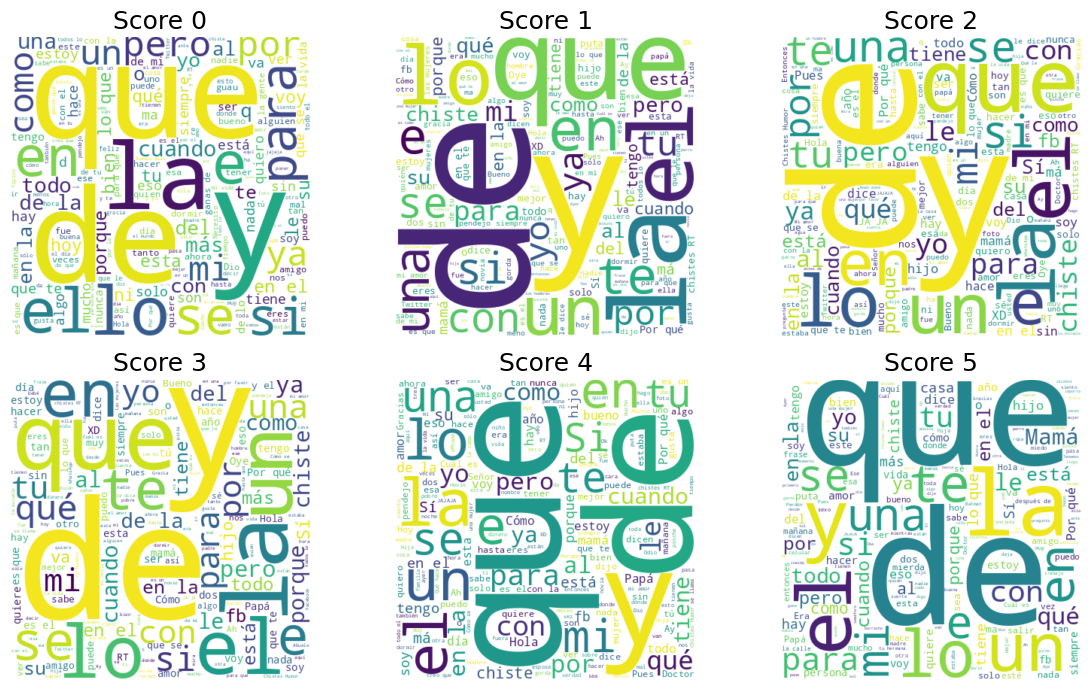

In [14]:
print("Nubes de tokens por clase:")
plot_wordclouds(tokens_per_class, tokens_set='tokens')

En el siguiente gráfico se muestran algunas de las palabras menos frecuentes encontradas por cada clase.

Nubes de tokens menos frecuentes por clase:


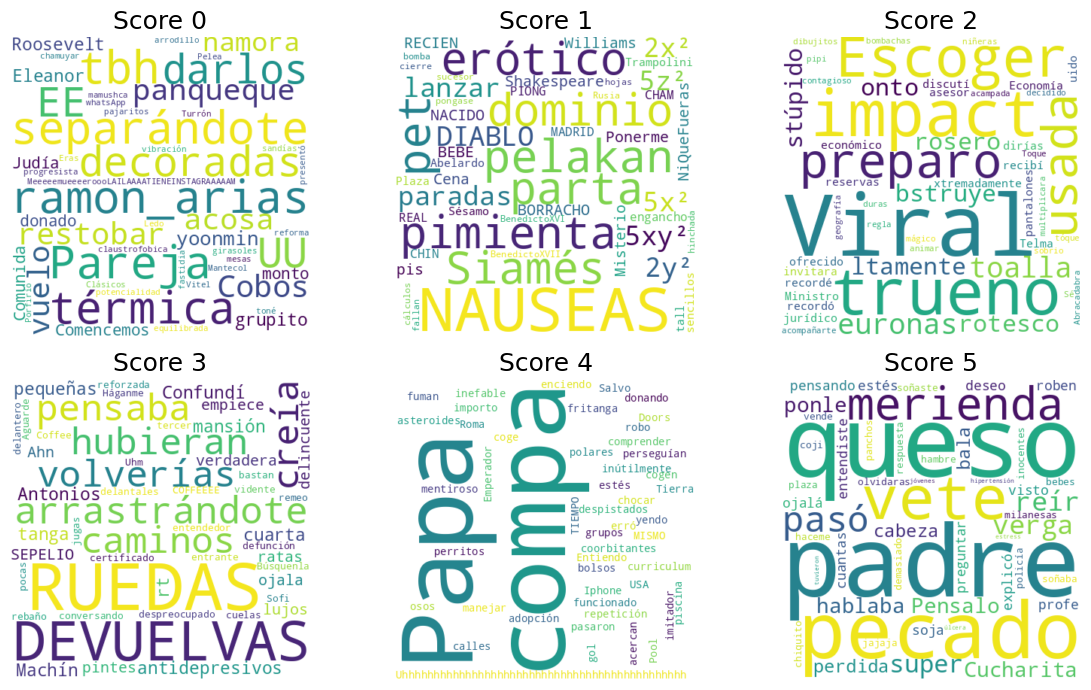

In [15]:
print("Nubes de tokens menos frecuentes por clase:")
plot_wordclouds(tokens_per_class, tokens_set='last200_tokens', max_words=50)

En el siguiente gráfico se muestran las palabras asociadas a humor encontradas por cada clase.

Nubes de tokens de humor presentes por clase:


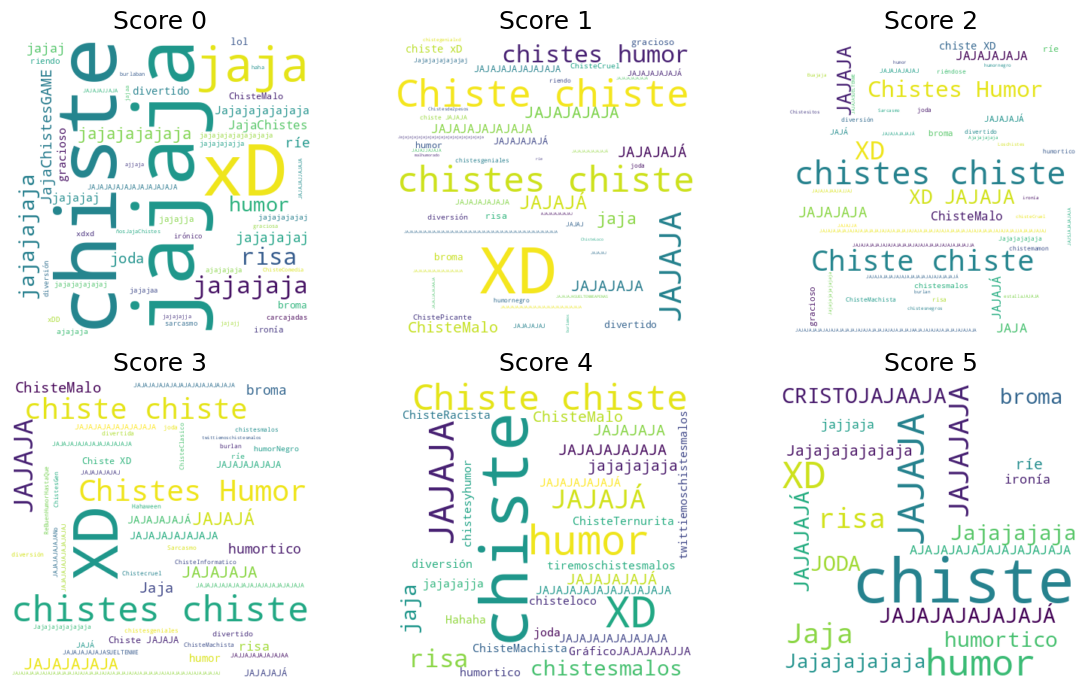

In [16]:
print("Nubes de tokens de humor presentes por clase:")
plot_wordclouds(tokens_per_class, tokens_set='humor_tokens', max_words=50)

In [17]:
all_humor_tokens = []
for score_class in score_classes:
  all_humor_tokens.extend(tokens_per_class[score_class]['humor_tokens'])

all_humor_tokens = list(set(all_humor_tokens))

print(f"Tokens de humor encontrados: {len(all_humor_tokens)}")

Tokens de humor encontrados: 347


Se encuentran un 347 tokens distintos en el dataset con significado de humor como 'chiste', 'jajajá' o 'humor'.

A continuación se calculará el porcentaje de instancias en el dataset con y sin estos tokens de humor para cada clase según la tarea detección o clasificación.

In [18]:
def count_humor_tokens(text):
  count = 0
  tokens = custom_tokenizer(text)
  for token in tokens:
    if contains_humor_words(token):
      count += 1

  return count

In [19]:
processed_df2 = processed_df.copy()
processed_df2['humor_tokens'] = processed_df2['text'].apply(lambda col: count_humor_tokens(col))

no_humor_counts = processed_df2[processed_df2['humor_tokens'] == 0]
no_humor_counts = no_humor_counts['score'].value_counts()
no_humor_counts = no_humor_counts.sort_index()

humor_counts = processed_df2[processed_df2['humor_tokens'] > 0]
humor_counts = humor_counts['score'].value_counts()
humor_counts = humor_counts.sort_index()

In [20]:
def plot_bars_humor_tokens(humor_counts: pd.Series, no_humor_counts: pd.Series, classes_list: list[str]):
  """
  Presenta un gráfico de barras apilado para conteos de textos con/sin tokens de humor en el dataset.
  """
  total_counts = humor_counts + no_humor_counts
  no_humor_percentages = no_humor_counts / total_counts * 100
  humor_percentages = humor_counts / total_counts * 100

  bottom = pd.Series([0]*len(classes_list))

  figsize = (5, 5) if len(classes_list) == 2 else (8, 5)
  plt.figure(figsize=figsize)
  plt.bar(classes_list, no_humor_counts, bottom=bottom, color='skyblue', label='Instancias sin tokens de humor')

  for score_class in classes_list:
    x = score_class
    y = bottom[score_class] + no_humor_counts[score_class]/2
    y = 500 if y < 100 else y
    label = f'{no_humor_counts[score_class]:,} ({no_humor_percentages[score_class]:.1f}%)'
    plt.text(x, y, label, ha='center', va='center', fontsize=9, color='black')

  bottom += no_humor_counts
  plt.bar(classes_list, humor_counts, bottom=bottom, color='orange', label='Instancias con tokens de humor')

  for score_class in classes_list:
    x = score_class
    y = bottom[score_class] + humor_counts[score_class]/2
    y = 1000 if y < 200 else y
    label = f'{humor_counts[score_class]:,} ({humor_percentages[score_class]:.1f}%)'
    plt.text(x, y, label, ha='center', va='center', fontsize=9, color='black')

  bottom += humor_counts

  for score_class in classes_list:
    x = score_class
    y = bottom[score_class] + 400
    y = 1600 if y < 1000 else y
    label = f'{total_counts[score_class]:,}'
    plt.text(x, y, label, ha='center', va='center', fontsize=9, color='black', fontweight='bold')

  plt.xticks(classes_list)
  plt.xlabel('Clases')
  plt.ylabel('Instancias')
  task = 'Detección' if len(classes_list) == 2 else 'Clasificación'
  title = f'{task} - Instancias con/sin tokens de humor por clase'
  plt.title(title)
  plt.legend()
  plt.tight_layout()
  plt.show()

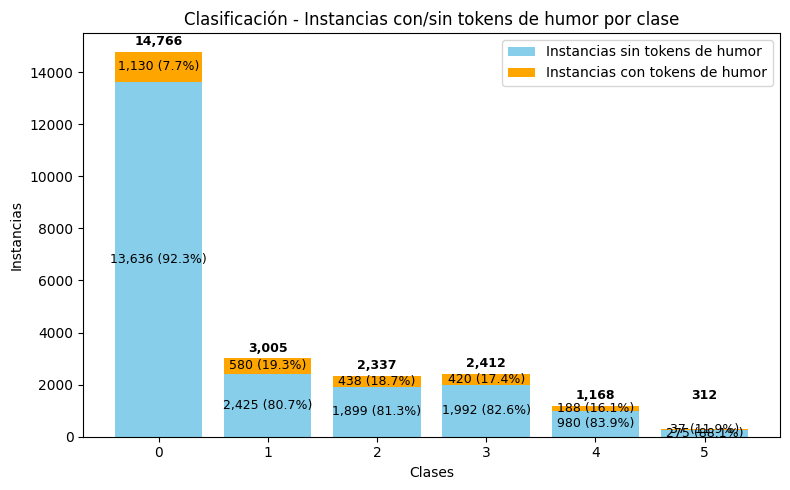

In [21]:
plot_bars_humor_tokens(humor_counts, no_humor_counts, score_classes)

Para la tarea de clasificación, de las instancias etiquetadas con un nivel de humor (del 1 al 5), entre un 14% al 19% aproximadamente tienen tokens de humor.


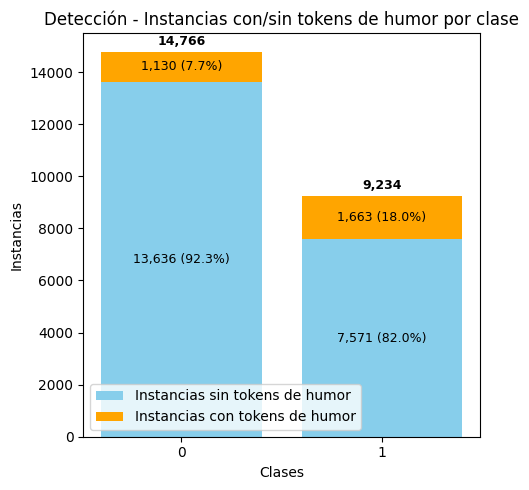

In [22]:
humor_counts2 = pd.Series([humor_counts.iloc[0], humor_counts.iloc[1:].sum()], index=[0, 1])
no_humor_counts2 = pd.Series([no_humor_counts.iloc[0], no_humor_counts.iloc[1:].sum()], index=[0, 1])

plot_bars_humor_tokens(humor_counts2, no_humor_counts2, detection_classes)

Para la tarea de detección, de las instancias etiquetadas como humor (clase 1), el 18% tienen tokens de humor.


## 2. Análisis de longitud de textos


En esta sección del notebook se hace un análisis de las longitudes de los textos en cada clase.

In [23]:
processed_df3 = processed_df.copy()
processed_df3['length'] = processed_df2['text'].str.len()

In [24]:
def plot_histogram_text_lengths(data_df: pd.DataFrame, bins=10, class_label='0'):
  """
  Presenta un histograma de las longitudes de textos.
  """
  plt.figure(figsize=(8, 5))
  plt.hist(data_df['length'], bins=bins, color='firebrick', edgecolor='firebrick')
  title = f'Distribución de las longitudes de textos (Clase {class_label})'
  plt.title(title)
  plt.xlabel('Longitud de textos (caracteres)')
  plt.ylabel('Frecuencia')
  plt.grid(True)
  plt.show()

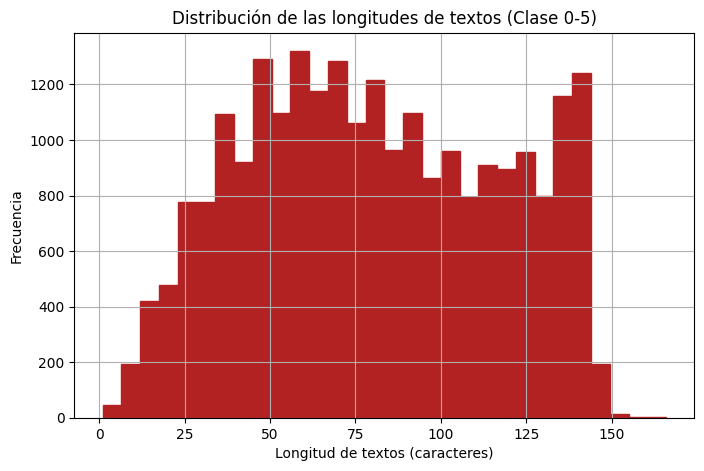

In [25]:
plot_histogram_text_lengths(processed_df3, bins=30, class_label='0-5')

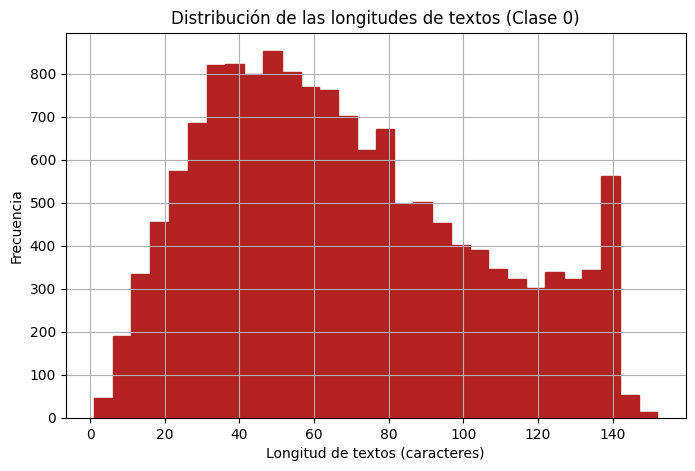

In [26]:
negative_lengths_df = processed_df3[processed_df3['score'] == 0]

plot_histogram_text_lengths(negative_lengths_df, bins=30, class_label='0')

Del histograma se observa que la mayoría de textos clasificados como no humor (clase 0) tienen una longitud entre 20 y 100 caracteres. Algunos textos de longitud superior a 120 caracteres fueron etiquetados sin humor. Los textos clasificados como no humor tienden a ser de tamaño pequeño o medio.


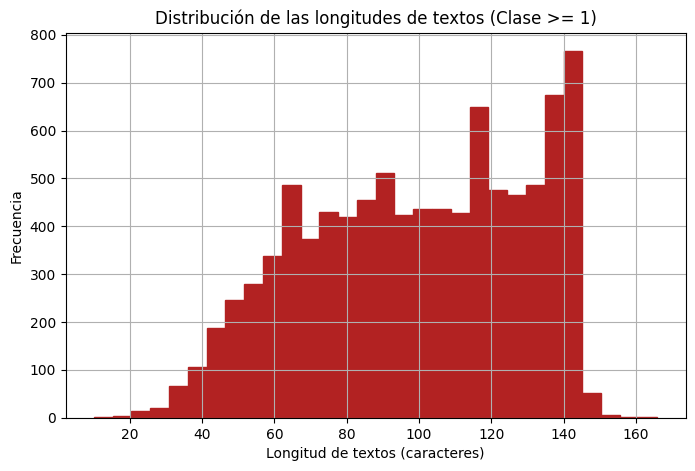

In [27]:
positive_lengths_df = processed_df3[processed_df3['score'] >= 1]

plot_histogram_text_lengths(positive_lengths_df, bins=30, class_label='>= 1')

Del histograma se observa que muchos textos de longitudes grandes superiores a 80 caracteres fueron etiquetados con algún nivel de humor (del 1 al 5). Los textos clasificados como humor tienden a ser de tamaño medio y largo.


## 3. Generación de dataset sintético


### 3.1. Dataset sintético con tokens de humor


Se genera un dataset sintético de 2000 instancias de texto de tamaño aleatorio, con tokens de humor junto con tokens seleccionados del vocabulario, clasificados como no humor (clase 0). Los pasos para cosntruir el dataset son:

- Se fija un tamaño de texto aleatorio entre límites A y B.
- Seleccionar N tokens de humor del conjunto total de tokens de humor.
- Seleccionar M tokens del conjunto de tokens únicos de clase no humor 0 hasta alcanzar el tamaño de texto fijado.
- Todos los textos se marcan como clase no humor 0.

El objetivo es generar un dataset que equilibre la proporción de instancias de textos con/sin tokens de humor.


In [28]:
negative_vocab = []
for score_class in score_classes[1:]:
  negative_vocab.extend(tokens_per_class[score_class]['tokens'])

negative_vocab = list(set(negative_vocab))

print(f"Tokens únicos de Clase 0: {len(negative_vocab)}")

Tokens únicos de Clase 0: 22082


In [29]:
def generate_humor_synthetic_df(negative_vocab: list[str],
                                all_humor_tokens: list[str],
                                rows=10,
                                humor_tokens=1,
                                length_limits=(10, 30)) -> pd.DataFrame:
  """
  Genera un DataFrame de textos sintéticos con tokens de humor y tokens del vocabulario
  de la clase no humor 0.
  """
  
  data = []

  for _ in range(rows):
    target_length = random.randint(length_limits[0], length_limits[1])
    random_humor_tokens = random.sample(all_humor_tokens, humor_tokens)
    text_value = " ".join(random_humor_tokens)

    while len(text_value) < target_length:
      random_token = random.choice(negative_vocab)
      text_value = text_value + " " + random_token

    data.append({'text': text_value, 'score': 0})

  result_df = pd.DataFrame(data)
  return result_df

In [30]:
synthetic_humor_df = generate_humor_synthetic_df(negative_vocab,
                                                 all_humor_tokens,
                                                 rows=2000,
                                                 humor_tokens=1,
                                                 length_limits=(85, 135))

synthetic_humor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   score   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [31]:
synthetic_humor_df.head(10)

,text,score
0,Jajajajajajajajajajajajajaja horny ENTIENDE ne...,0
1,😅 Alcatel batí Vidas Jovi jaj Sígueme ejecutar...,0
2,jajaj Contestame renault revisaría club sanará...,0
3,jajajs impact casa amorSUELTA inú próxima sele...,0
4,ajjaja bajo cigalo comunión equivocan rotesco ...,0
5,tiposJAJAJA obra mini viajando cosota clínica ...,0
6,Loschistes Pasito foto pégale 🍔 uy Aspirina di...,0
7,XD acabando auriculares Adelante Lohan unida N...,0
8,LoL llegara tuviera tardas verdugo presumido T...,0
9,burla la tendiendo ENDOSCOPIO devuelve lan Ing...,0


In [32]:
synthetic_dir_path = "../data/synthetic"
if not os.path.exists(synthetic_dir_path):
  os.makedirs(synthetic_dir_path)

In [33]:
synthetic_humor_file_path = os.path.join(synthetic_dir_path, "haha_train_synthetic_humor.csv")

synthetic_humor_df.to_csv(synthetic_humor_file_path, sep=',', encoding='utf-8', index=False)

### 3.2. Dataset sintético con tokens menos frecuentes


Se genera un dataset sintético de 2000 ejemplos construido con textos originales del dataset de entrenamiento concatenado con tokens menos frecuentes de la clase contraria. Los pasos para construir el dataset son:

- Se toman textos aleatorios del dataset original de las clases humor 0 y no humor 1-5.
- A los textos de clase 0 se le agregan N tokens aleatorios del conjunto de tokens menos frecuentes en la clase humor 1-5.
- Y a los textos de clase 1-5 se le agregan N tokens aleatorios del conjunto de tokens menos frecuentes de la clase no humor 0.

El objetivo es generar un dataset a prueba de memorización de palabras menos frecuentes.


In [34]:
def generate_frequency_synthetic_df(processed_df: pd.DataFrame,
                                    tokens_per_class: dict,
                                    rows=50,
                                    least_frequent_tokens=1) -> pd.DataFrame:
  """
  Genera un DataFrame de textos sintéticos con instancias del dataset original con tokens menos
  frecuentes del vocabulario de la clase opuesta.
  """

  data = []
  total = len(processed_df)

  for _ in range(rows):
    selected_row = random.randint(0, total-1)

    selected_text = processed_df.iloc[selected_row]['text']
    selected_score = processed_df.iloc[selected_row]['score']

    opposite_score = 0
    if selected_score == 0:
      opposite_score = random.randint(score_classes[1], score_classes[-1])
    else:
      opposite_score = 0

    last200_tokens = tokens_per_class[opposite_score]['last200_tokens']
    random_tokens = random.sample(last200_tokens, least_frequent_tokens)

    text_value = " ".join(random_tokens)
    text_value = selected_text + " " + text_value

    data.append({'text': text_value, 'score': selected_score})

  result_df = pd.DataFrame(data)
  return result_df

In [35]:
synthetic_freq_df = generate_frequency_synthetic_df(processed_df,
                                                    tokens_per_class,
                                                    rows=2000,
                                                    least_frequent_tokens=1)

synthetic_freq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   score   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [36]:
synthetic_freq_df.head(10)

,text,score
0,Temores de antes:\r\n—La llorona.\r\n—La bruja...,4
1,Aprender es como remar contra corriente: en cu...,0
2,ME ENOJO CUANDO no le ponen queso a las quesad...,0
3,"Cuando la gente NO sigue ""reglas"" entonces hay...",0
4,QUIERO GANAR NEGRO PLS #JoelVerdugoDeLeopoldo ego,0
5,Un ciego le pregunta a un cojo:\r\n- ¿Qué tal ...,2
6,Dejen de bardear a pepo les voy a dar un palaz...,0
7,hola ma? t acordas cuando me ibas a buscar a l...,2
8,En vivo @splendid1040 en charla con el preside...,0
9,"alv hoy no iré a la facu, soy más mocos que pe...",0


In [37]:
synthetic_freq_file_path = os.path.join(synthetic_dir_path, "haha_train_synthetic_frequency.csv")

synthetic_freq_df.to_csv(synthetic_freq_file_path, sep=',', encoding='utf-8', index=False)

### 3.3. Dataset sintético de longitud cortas y largas


Se genera un dataset sintético de 2000 ejemplos construido con tokens de cada clase. Los pasos para construir el dataset son:

- Se fija un tamaño mínimo entre 2 y 4 desviaciones estándar de la longitud de textos por clase (no humor 0 y humor 1-5).
- Se construyen textos tomando tokens aleatorios del conjunto tokens únicos por clase hasta alcanzar el tamaño de texto fijado.

El objetivo es generar un dataset aprueba de longitudes de texto extremas.


In [38]:
stats_per_class = {}
for score_class in score_classes:
  partition_df = processed_df3[processed_df3['score'] == score_class]
  stats_per_class[score_class] = {
    'mean': partition_df['length'].mean(),
    'std': partition_df['length'].std()
  }

stats_per_class

{0: {'mean': 68.31118786401191, 'std': 35.30649036970204},
 1: {'mean': 99.34608985024958, 'std': 30.875151641194538},
 2: {'mean': 99.81985451433462, 'std': 30.02233157669042},
 3: {'mean': 99.20978441127694, 'std': 30.206724834947057},
 4: {'mean': 98.33904109589041, 'std': 30.412724242058662},
 5: {'mean': 95.87820512820512, 'std': 32.046859370021}}

In [39]:
def generate_lengths_synthetic_df(tokens_per_class: dict,
                                  stats_per_class: dict,
                                  rows=10) -> pd.DataFrame:
  """
  Genera un DataFrame de textos sintéticos de tamaño entre 2 y 4 desviaciones estándar con tokens
  aleatorios tomados de la clase seleccionada.
  """

  data = []

  for _ in range(rows):
    selected_score = random.randint(score_classes[0], score_classes[-1])

    mean = stats_per_class[selected_score]['mean']
    std = stats_per_class[selected_score]['std']
    min_length = math.floor(mean+std*2)
    max_length = math.floor(mean+std*4)

    target_length = random.randint(min_length, max_length)

    unique_tokens = tokens_per_class[selected_score]['unique_tokens']

    random_token = random.choice(unique_tokens)
    text_value = random_token

    while len(text_value) < target_length:
      random_token = random.choice(unique_tokens)
      text_value = text_value + " " + random_token

    data.append({'text': text_value, 'score': selected_score})

  result_df = pd.DataFrame(data)
  return result_df

In [40]:
synthetic_lengths_df = generate_lengths_synthetic_df(tokens_per_class,
                                                     stats_per_class,
                                                     rows=2000)

synthetic_lengths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   score   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [41]:
synthetic_lengths_df.head(10)

,text,score
0,chavas enciende interrumpir fumar Comida Jetta...,2
1,Hablemos Ｄｉｅｇｏ Para Cuántos Anhelo guitarra ba...,1
2,Exactovsky tres atropellé Todas TARTAMUDO Prof...,5
3,pásale perderse y gokupokemondrakeyjosh1995 Do...,5
4,it CRISTIANO romántico geografía contradiga ch...,2
5,fintas Paw frenos amable conoce rotesco grupos...,2
6,freno medio dificil donador GoldenTriumph Amig...,3
7,encuentra blancos persona colta invocar huevit...,3
8,Wingardium jugos Contras follando oliendo prof...,4
9,rimel Colores Falu chistosita vivo Lloré olead...,0


In [42]:
synthetic_lenghts_file_path = os.path.join(synthetic_dir_path, "haha_train_synthetic_lengths.csv")

synthetic_lengths_df.to_csv(synthetic_lenghts_file_path, sep=',', encoding='utf-8', index=False)